# ENGO 645 Final Project: Dimensionality Reduction, Model Selection

By: Lalitha Guru Swaminathan, Mabel Heffring, Saroj Kumar

## Part 1: Dimensionality Reduction
### Step 1: Reading in Data
- Reading in the river and lake data and printing the info

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'../data/cleaned/wq_all.csv' 
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15385 entries, 0 to 15384
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   StationNumber                              15385 non-null  object 
 1   Latitude                                   15385 non-null  float64
 2   Longitude                                  15385 non-null  float64
 3   SampleDatetime                             15385 non-null  object 
 4   RiverSubBasinCode                          15385 non-null  object 
 5   100923 PH (FIELD) pH units                 15385 non-null  float64
 6   80558 OXYGEN DISSOLVED (FIELD METER) mg/L  15385 non-null  float64
 7   100924 SPECIFIC CONDUCTANCE (FIELD) uS/cm  15385 non-null  float64
 8   100925 TEMPERATURE WATER deg C             15385 non-null  float64
 9   Year                                       15385 non-null  int64  
 10  Month                 

### Step 2: Organinizing Data for Dimensionality Reduction
- Map column names for PCA
- Filter only for water quality parameters
- Ensure there are no missing values
- Standardize the features

In [2]:
# Mapping column names 
columns_rename = {
    '100923 PH (FIELD) pH units': 'pH',
    '80558 OXYGEN DISSOLVED (FIELD METER) mg/L': 'Oxygen',
    '100924 SPECIFIC CONDUCTANCE (FIELD) uS/cm': 'Conductance',
    '100925 TEMPERATURE WATER deg C': 'WaterTemp'
}

# Rename columns in the original DataFrame
df.rename(columns=columns_rename, inplace=True)

# Select the renamed columns for PCA
columns_for_pca = list(columns_rename.values())
df_pca = df[columns_for_pca]

# filtering for water quality features
features = ['pH', 'Oxygen', 'Conductance', 'WaterTemp']
X = df[features]

# removing missing values
X = X.dropna()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Step 3: Perform PCA
- perform PCA on the WQ features
- use the features variance to create a weighted score of all PCA components (this is the new WQI index)
- map and plot scores for analysis

In [3]:
# Perform PCA
pca = PCA()
pca_components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=pca_components, 
                      columns=[f'PC{i+1}' for i in range(len(features))])

df_pca

PC1       PC2       PC3       PC4
0     -1.030629 -0.655370 -2.828683 -0.138729
1     -1.843700 -0.655975 -2.561445 -0.806602
2     -1.843700 -0.655975 -2.561445 -0.806602
3     -1.879239 -0.498151 -2.376446 -0.260537
4     -1.808101 -0.627433 -2.590965 -0.795029
...         ...       ...       ...       ...
15380 -2.484134  2.092525 -0.621557  0.529191
15381 -2.497589  2.094255 -0.622777  0.515616
15382 -2.582831  2.096259 -0.612427  0.416968
15383 -2.607534  2.101051 -0.612055  0.388297
15384 -2.618782  2.104113 -0.610463  0.373200

[15385 rows x 4 columns]

In [4]:
# calculate the variance
variances = df_pca.var(axis=0)

# compute the total variance
total_variance = variances.sum()

# compute the weights (explained variance ratios)
weights = variances / total_variance

# compute the score as the weighted sum of PCs for each data point
score = df_pca.dot(weights)

# Add the score to the DataFrame for reference
df['score'] = score

# transforming scores into bins (for classification)
bin_edges = [float('-inf'), -2, -1.6667, -1.3334, -1.0, -0.6667, -0.3334, 0, 0.3334, 0.6667, 1.0, 1.3334, 1.6667, 2.0, float('inf')]

bin_labels = ['<-2', '-2 - -1.6667', '-1.6667 - -1.3334', '-1.3334 - -1.0', '-1.0 - -0.6667', '-0.6667 - -0.3334', '-0.3334 - 0', '0 - 0.3334', '0.3334 - 0.6667', '0.6667 - 1.0', '1.0 - 1.3334', '1.3334 - 1.6667', '1.6667 - 2.0', '>2.0']

df['score_class'] = pd.cut(df['score'], bins=bin_edges, labels=bin_labels, right=False)

# Display the weights for reference
print("\nWeights (explained variance ratios):")
print(weights)
df.info()


Weights (explained variance ratios):
PC1    0.490229
PC2    0.257733
PC3    0.177944
PC4    0.074095
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15385 entries, 0 to 15384
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   StationNumber      15385 non-null  object  
 1   Latitude           15385 non-null  float64 
 2   Longitude          15385 non-null  float64 
 3   SampleDatetime     15385 non-null  object  
 4   RiverSubBasinCode  15385 non-null  object  
 5   pH                 15385 non-null  float64 
 6   Oxygen             15385 non-null  float64 
 7   Conductance        15385 non-null  float64 
 8   WaterTemp          15385 non-null  float64 
 9   Year               15385 non-null  int64   
 10  Month              15385 non-null  int64   
 11  Elevation          15385 non-null  float64 
 12  Slope              15385 non-null  float64 
 13  LC_5km             15385 non-null 

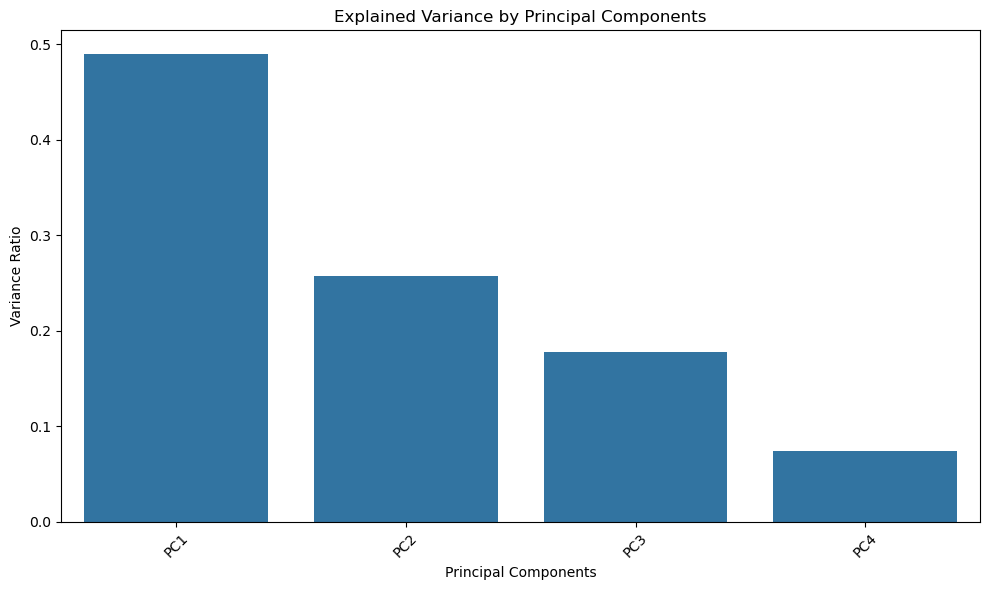

PC1: 49.02%
PC2: 25.77%
PC3: 17.79%
PC4: 7.41%


In [5]:
# plotting explained variance
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10,6))
sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance)
plt.title('Explained Variance by Principal Components')
plt.ylabel('Variance Ratio')
plt.xlabel('Principal Components')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('../imgs/PCA_explained_variance.png')
plt.show()

# printing out the explained variance components
for i, var in enumerate(explained_variance, 1):
    print(f'PC{i}: {var:.2%}')

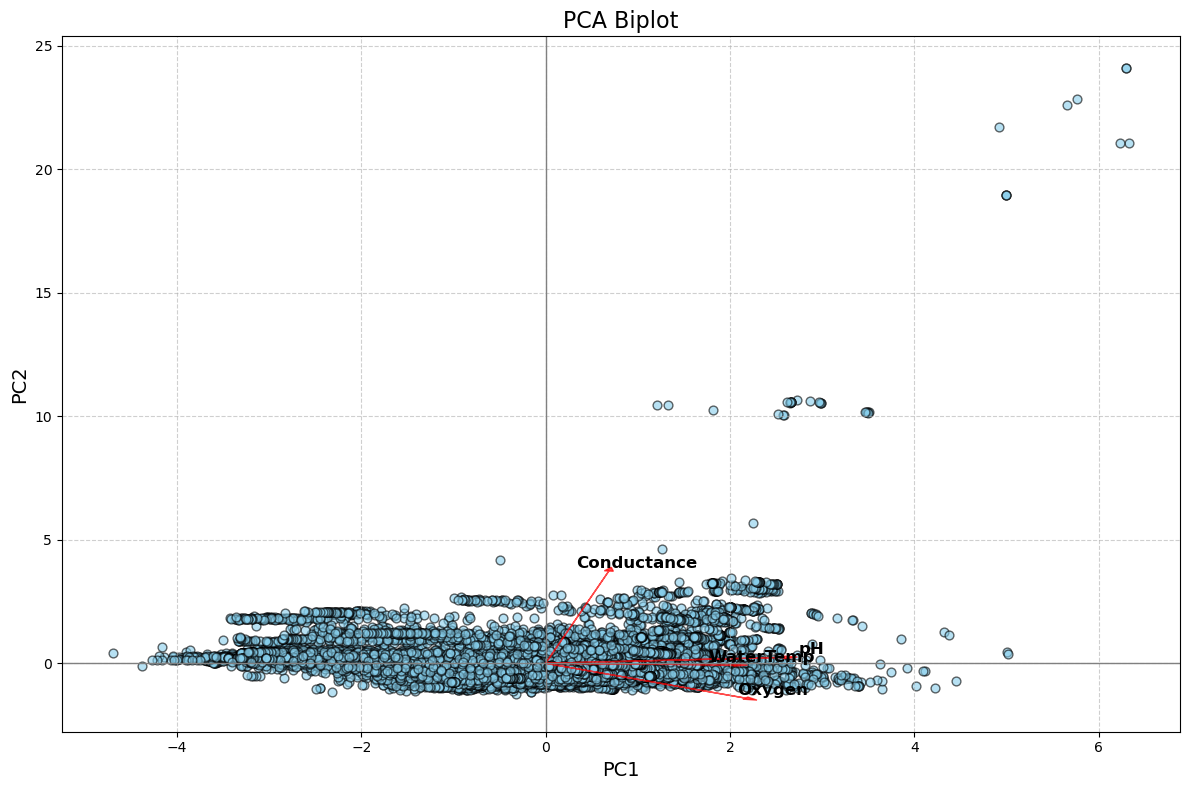

In [6]:
# plotting biplot for PCA
import numpy as np
import matplotlib.pyplot as plt

def biplot(score, coeff, labels=None, scale=4, text_offset=0.3):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    
    plt.figure(figsize=(12, 8))
    
    # Scatter plot with clearer dots
    plt.scatter(xs, ys, alpha=0.6, color='skyblue', edgecolor='black', s=40)
    
    # Draw arrows and variable labels
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0] * scale, coeff[i, 1] * scale,
                  color='red', alpha=0.7, head_width=0.1)
        
        label = labels[i] if labels else f"Var{i+1}"
        
        # Add label (without background)
        plt.text(coeff[i, 0] * scale + text_offset,
                 coeff[i, 1] * scale + text_offset,
                 label,
                 color='black', fontsize=12, weight='bold', ha='center', va='center')
    
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.title("PCA Biplot", fontsize=16)
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('../imgs/PCA_biplot.png')
    plt.show()

biplot(pca_components, pca.components_.T, labels=features)


In [7]:
# Mapping stations according to PCA value
import geopandas as gpd
import folium
import matplotlib.colors as mcolors

# Extracting scores for a specific month and year
YEAR = 2021
MONTH = 10
filtered_df = df[(df['Year'] == YEAR) & (df['Month'] == MONTH)]

# converting to geopandas
gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['Longitude'], filtered_df['Latitude']))

# set crs
gdf = gdf.set_crs(epsg=4326)

# Create a folium map object
f = folium.Figure(width=800, height=500) # set figure size

# define the center coordinate of your city
center_latitude = np.mean(gdf['Latitude'])
center_longitude = np.mean(gdf['Longitude'])

# Create the Folium map
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=5).add_to(f)

# create custom colour map for airbnb prices
min_score = gdf['score'].min()
max_score = gdf['score'].max()
norm = mcolors.Normalize(vmin=min_score, vmax=max_score)
cmap = plt.get_cmap('YlOrRd') 

# plotting airbnb with colours based on price
for index, row in gdf.iterrows():
    color = mcolors.to_hex(cmap(norm(row['score'])))  # Get color for price
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=2,
        color=color,
        fill=True,
        fill_opacity=1.0,
        popup=f"Station Number: {row['StationNumber']}, WQ Score: {row['score']}",
        tooltip='Click for more info'
    ).add_to(m)


# display the map
m.save(f'../imgs/WQI_map_{YEAR}_{MONTH}.html')
m


## Part 2: Model Selection
### Step 1: Preparing data for training
- normalizing categorical and numerical columns
- extracting training, validation, and testing subsets

In [26]:
# data preparation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Drop 'SampleDatetime'
df_cleaned = df.drop(['SampleDatetime','StationNumber', 'Latitude', 'Longitude', 'pH', 'Oxygen', 'Conductance',  'WaterTemp',  'Year'],  axis=1)

# Separate features and target
if 'score_class_encoded' in df_cleaned.columns:
    X = df_cleaned.drop(['score', 'score_class', 'score_class_encoded'], axis=1)
else:
    X = df_cleaned.drop(['score', 'score_class'], axis=1)
y = df_cleaned['score']

# Identify categorical and numerical columns
categorical_cols = ['RiverSubBasinCode']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ]
)

# (CLASSES) Define preprocessor
preprocessor_classes = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ]
)

# encoding the score class
label_encoder_score = LabelEncoder()
label_encoder_score.fit(df['score_class'])
df['score_class_encoded'] = label_encoder_score.transform(df['score_class'])

y_class = df['score_class_encoded']

# Split data: 80% train, 10% validation, 10% test
# First, split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# Then, split temp into validation (50% of temp) and test (50% of temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# (CLASSES) Split data: 80% train, 10% validation, 10% test
# First, split into train (80%) and temp (20%)
X_train_class, X_temp_class, y_train_class, y_temp_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
# Then, split temp into validation (50% of temp) and test (50% of temp)
X_val_class, X_test_class, y_val_class, y_test_class = train_test_split(X_temp_class, y_temp_class, test_size=0.5, random_state=42)

# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# (CLASSES) Apply preprocessing
X_train_class_transformed = preprocessor_classes.fit_transform(X_train_class)
X_val_class_transformed = preprocessor_classes.transform(X_val_class)
X_test_class_transformed = preprocessor_classes.transform(X_test_class)

# Convert sparse matrices to dense arrays for PyTorch
X_train_transformed = X_train_transformed.toarray()
X_val_transformed = X_val_transformed.toarray()
X_test_transformed = X_test_transformed.toarray()

# Convert to PyTorch tensors
import torch

X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_transformed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print(f"Training set shape: {X_train_tensor.shape}")
print(f"Validation set shape: {X_val_tensor.shape}")
print(f"Test set shape: {X_test_tensor.shape}")

Training set shape: torch.Size([12308, 79])
Validation set shape: torch.Size([1538, 79])
Test set shape: torch.Size([1539, 79])


### Step 2: Train Regressors
- training Random Forest Regressor and MLP
- predicting WQI derived in PCA
- visualize results

***MULTI LAYER PERCEPTRON (MLP)***

In [27]:
# setting up architecture
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = X_train_tensor.shape[1]
model = MLP(input_dim)

In [28]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
num_epochs = 100
train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Test phase
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 10/100, Train Loss: 0.3195, Val Loss: 0.3044, Test Loss: 0.2622
Epoch 20/100, Train Loss: 0.2702, Val Loss: 0.2713, Test Loss: 0.2440
Epoch 30/100, Train Loss: 0.2592, Val Loss: 0.2648, Test Loss: 0.2376
Epoch 40/100, Train Loss: 0.2514, Val Loss: 0.2559, Test Loss: 0.2349
Epoch 50/100, Train Loss: 0.2448, Val Loss: 0.2530, Test Loss: 0.2335
Epoch 60/100, Train Loss: 0.2414, Val Loss: 0.2485, Test Loss: 0.2307
Epoch 70/100, Train Loss: 0.2402, Val Loss: 0.2488, Test Loss: 0.2299
Epoch 80/100, Train Loss: 0.2371, Val Loss: 0.2426, Test Loss: 0.2297
Epoch 90/100, Train Loss: 0.2331, Val Loss: 0.2464, Test Loss: 0.2272
Epoch 100/100, Train Loss: 0.2378, Val Loss: 0.2493, Test Loss: 0.2267


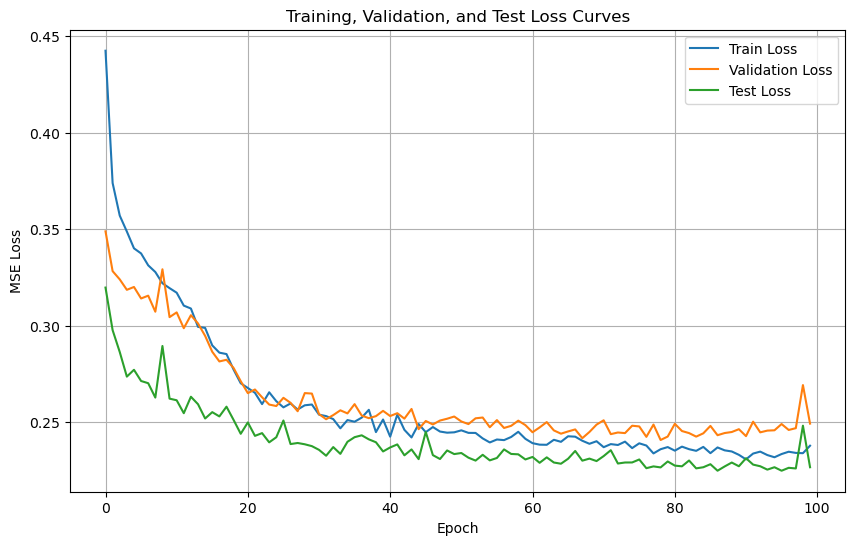

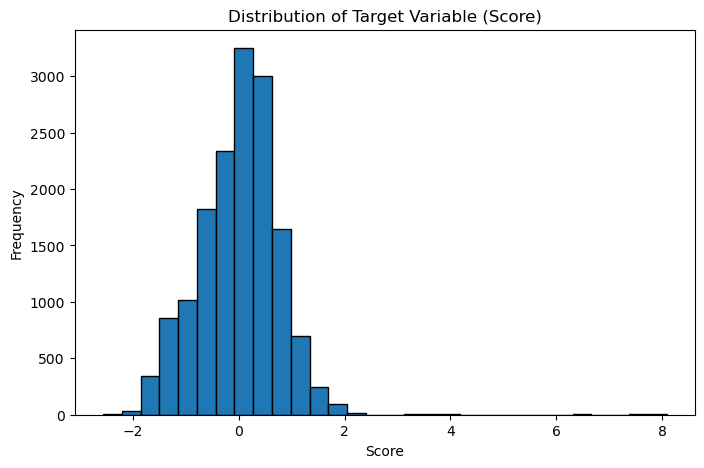

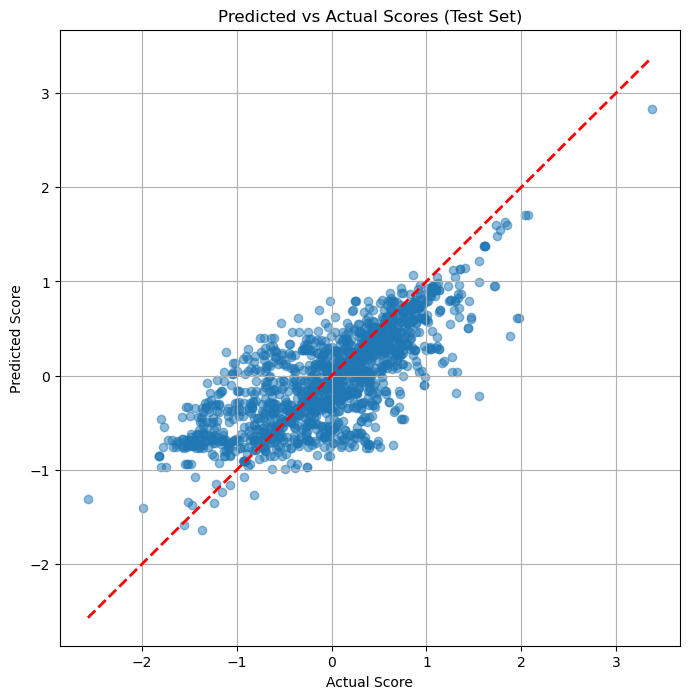

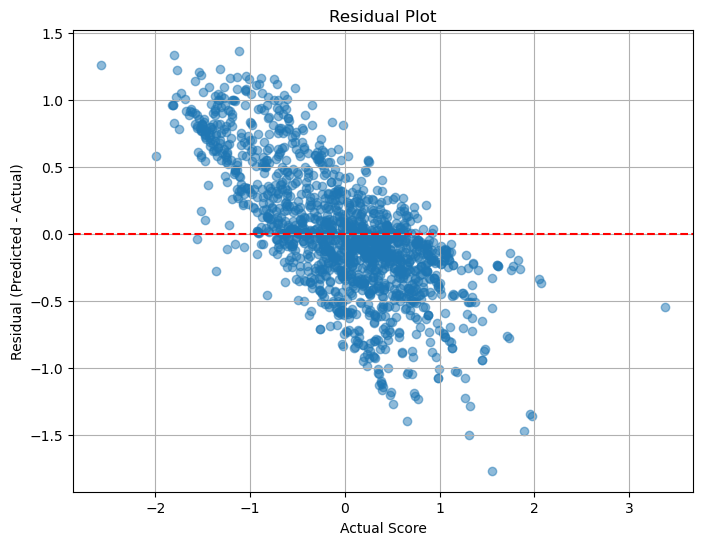

=== Basic Regression Metrics ===
Mean Absolute Error (MAE): 0.3593
Mean Squared Error (MSE): 0.2267
Root Mean Squared Error (RMSE): 0.4761
R-squared (R²): 0.5644

=== Advanced Regression Metrics ===
Mean Absolute Percentage Error (MAPE): 282.4202%
Symmetric Mean Absolute Percentage Error (SMAPE): 90.1709%
Nash-Sutcliffe Efficiency (NSE): 0.5644
Relative Absolute Error (RAE): 0.6233
Relative Root Mean Squared Error (RRMSE): -14.1189
Kling-Gupta Efficiency (KGE): 0.5741


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define additional regression metrics
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)
    Measures average percentage error between predicted and actual values"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by adding a small epsilon where y_true is zero
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    A variation of MAPE that handles zero or near-zero values better"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)) * 100

def nash_sutcliffe_efficiency(y_true, y_pred):
    """Calculate Nash-Sutcliffe Efficiency (NSE)
    Measures how well the model predicts compared to using the mean of observed data"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def relative_absolute_error(y_true, y_pred):
    """Calculate Relative Absolute Error (RAE)
    Normalizes the total absolute error by dividing by the total absolute deviation"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def relative_root_mean_squared_error(y_true, y_pred):
    """Calculate Relative Root Mean Squared Error (RRMSE)
    RMSE normalized by the mean of the actual values"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.mean(y_true) + 1e-10)

def kling_gupta_efficiency(y_true, y_pred):
    """Calculate Kling-Gupta Efficiency (KGE)
    Combines correlation, bias, and variability components"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.sum(y_pred) / (np.sum(y_true) + 1e-10)
    alpha = np.std(y_pred) / (np.std(y_true) + 1e-10)
    return 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# Loss curves - Make sure train_losses, val_losses, and test_losses are defined
# before running this section
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig('../imgs/MLP_training_curves.png')
plt.show()

# Target distribution - Make sure 'y' is defined before running this section
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable (Score)')
plt.savefig('../imgs/Target_Variable_Distribution.png')
plt.show()

# Generate predictions on the test set
model.eval()  # Set model to evaluation mode
y_pred = []
y_true = []
with torch.no_grad():  # Disable gradient calculation for inference
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        # Convert tensors to Python lists for metric calculation
        y_pred.extend(outputs.detach().cpu().flatten().tolist())
        y_true.extend(y_batch.detach().cpu().flatten().tolist())

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
# Add perfect prediction line (y=x)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Predicted vs Actual Scores (Test Set)')
plt.grid(True)
plt.savefig('../imgs/MLP_predicted_vs_actual.png')
plt.show()

# Create residual plot (predicted - actual)
plt.figure(figsize=(8, 6))
residuals = np.array(y_pred) - np.array(y_true)
plt.scatter(y_true, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Score')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True)
plt.savefig('../imgs/MLP_residuals.png')
plt.show()

# Compute basic regression metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Compute advanced regression metrics
mape = mean_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
nse = nash_sutcliffe_efficiency(y_true, y_pred)
rae = relative_absolute_error(y_true, y_pred)
rrmse = relative_root_mean_squared_error(y_true, y_pred)
kge = kling_gupta_efficiency(y_true, y_pred)

# Display all regression metrics
print("=== Basic Regression Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

print("\n=== Advanced Regression Metrics ===")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}%")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse:.4f}")
print(f"Relative Absolute Error (RAE): {rae:.4f}")
print(f"Relative Root Mean Squared Error (RRMSE): {rrmse:.4f}")
print(f"Kling-Gupta Efficiency (KGE): {kge:.4f}")

# Note: Removed classification metrics (confusion_matrix, classification_report, accuracy_score)
# as they are not appropriate for regression tasks with continuous predictions


***RANDOM FOREST REGRESSOR***

In [31]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train = X_train_class_transformed
y_train = y_train
X_test = X_test_class_transformed

rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=2)

# Fit it
grid_search.fit(X_train, y_train)

# predict with best model
best_model = grid_search.best_estimator_
print(grid_search.best_estimator_)
y_pred = best_model.predict(X_test)

# Compute basic regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display all regression metrics
print("=== Basic Regression Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
RandomForestRegressor(n_estimators=200, random_state=42)
=== Basic Regression Metrics ===
Mean Absolute Error (MAE): 0.3192
Mean Squared Error (MSE): 0.1997
Root Mean Squared Error (RMSE): 0.4469
R-squared (R²): 0.6163


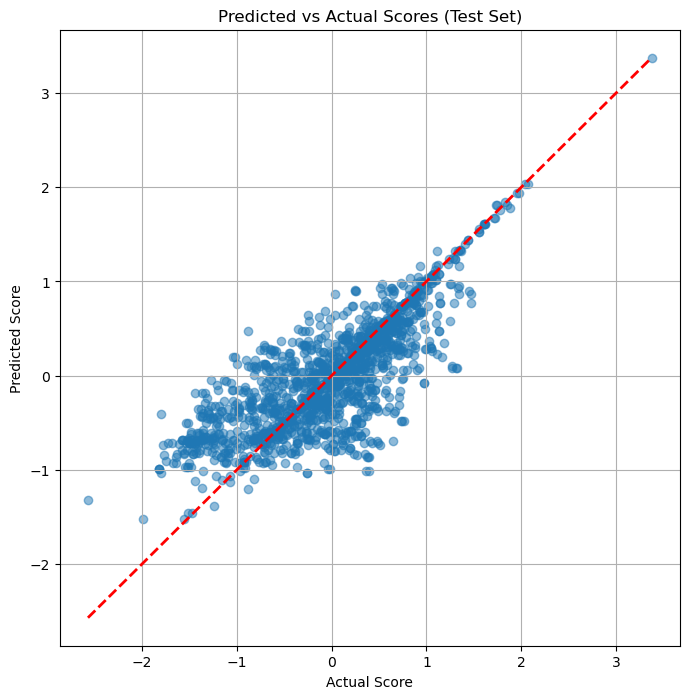

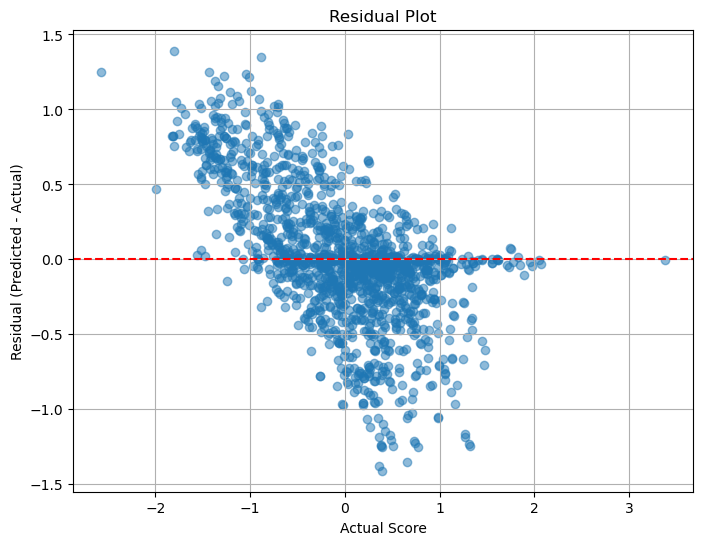

In [32]:
# Create scatter plot of predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
# Add perfect prediction line (y=x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Predicted vs Actual Scores (Test Set)')
plt.grid(True)
plt.savefig('../imgs/RF_predicted_vs_actual.png')
plt.show()

# Create residual plot (predicted - actual)
plt.figure(figsize=(8, 6))
residuals = np.array(y_pred) - np.array(y_test)
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Score')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.grid(True)
plt.savefig('../imgs/RF_residuals.png')
plt.show()

### Step 2: Train Classifiers
- training ID3, CART, NB, and ADABoost
- predicting WQI derived in PCA
- visualize results

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


# collect the evaluation metrics for ID3/C4.5
id3_accuracy = None
id3_precision = None
id3_recall = None
id3_f1 = None

# collect the evaluation metrics for CART
CART_accuracy = None
CART_precision = None
CART_recall = None
CART_f1 = None

# collect the evaluation metrics for Naive Bayes
NB_accuracy = None
NB_precision = None
NB_recall = None
NB_f1 = None

# collect the evaluation metrics for AdaBoost
AdaBoost_accuracy = None
AdaBoost_precision = None
AdaBoost_recall = None
AdaBoost_f1 = None

# mapping correct training, testing and predicting
X_train = X_train_class_transformed
X_test = X_val_class_transformed
X_pred = X_test_class_transformed
y_train = y_train_class
y_test = y_val_class
y_pred = y_test_class


# function for calculating metrics
def get_metrics(clf = None, X_test = None, y_test = None, y_pred = None):
    #  Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)

    # Precision Score
    precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)

    # Recall Score
    recall = recall_score(y_test, y_pred, average = 'macro')

    # F1 Score
    f1 = f1_score(y_test, y_pred, average = 'macro')

    return accuracy, precision, recall, f1

t0 = time.time()

# ~~~~~~~~~~~~~~~~~ID3 Decision Tree~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# building decision tree
clf_id3 = DecisionTreeClassifier(criterion='entropy', random_state=10)

# hyperparameters to test
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 13],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# GridSearchCV to test each hyperparameter configuration
grid_search_id3 = GridSearchCV(estimator=clf_id3, param_grid=dt_param_grid, cv=5)
# training different model configurations
grid_search_id3.fit(X_train, y_train)

# printing accuracy for different model configurations (to assess the impact of each hyperparameter)
grid_search_id3_results = pd.DataFrame(grid_search_id3.cv_results_)
id3_pivot_table_depth_leaf = grid_search_id3_results.pivot_table(values='mean_test_score', 
                                                                   index='param_max_depth', 
                                                                   columns='param_min_samples_leaf', 
                                                                   aggfunc='mean')
print("\nID3 max_depth vs. min_samples_leaf (accuracy) \n", id3_pivot_table_depth_leaf)
id3_pivot_table_depth_split = grid_search_id3_results.pivot_table(values='mean_test_score', 
                                                                    index='param_max_depth', 
                                                                    columns='param_min_samples_split', 
                                                                    aggfunc='mean')
print("\nID3 max_depth vs. min_samples_split (accuracy) \n", id3_pivot_table_depth_split)
# printing best model parameters
print("ID3 Best Parameters:", grid_search_id3.best_params_)

# getting best model and predicting using test dataset
id3_best_model = grid_search_id3.best_estimator_
y_pred = id3_best_model.predict(X_test)

# calculating quality metrics
id3_accuracy, id3_precision, id3_recall, id3_f1 = get_metrics(id3_best_model, X_test, y_test, y_pred)

# calculating time for ID3
t1 = time.time()
print("id3 time (s): ", str(t1-t0))

# ~~~~~~~~~~~~~~~~~CART Decision Tree~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# building decision tree
clf_CART = DecisionTreeClassifier(criterion='gini', random_state=10)

# GridSearchCV to test each hyperparameter configuration
grid_search_CART = GridSearchCV(estimator=clf_CART, param_grid=dt_param_grid, cv=5)
# training different model configurations
grid_search_CART.fit(X_train, y_train)

# printing accuracy for different model configurations (to assess the impact of each hyperparameter)
grid_search_CART_results = pd.DataFrame(grid_search_CART.cv_results_)
CART_pivot_table_depth_leaf = grid_search_CART_results.pivot_table(values='mean_test_score', 
                                                                   index='param_max_depth', 
                                                                   columns='param_min_samples_leaf', 
                                                                   aggfunc='mean')
print("\nCART max_depth vs. min_samples_leaf (accuracy) \n", CART_pivot_table_depth_leaf)
CART_pivot_table_depth_split = grid_search_CART_results.pivot_table(values='mean_test_score', 
                                                                    index='param_max_depth', 
                                                                    columns='param_min_samples_split', 
                                                                    aggfunc='mean')
print("\nCART max_depth vs. min_samples_split (accuracy) \n", CART_pivot_table_depth_split)
# printing best model parameters
print("CART Best Parameters:", grid_search_CART.best_params_)

# getting best model and predicting using test dataset
CART_best_model = grid_search_CART.best_estimator_
y_pred = CART_best_model.predict(X_test)

# calculating quality metrics
CART_accuracy, CART_precision, CART_recall, CART_f1 = get_metrics(CART_best_model, X_test, y_test, y_pred)

# calculating time for ID3
t2 = time.time()
print("CART time (s): ", str(t2-t1))

# ~~~~~~~~~~~~~~~~~Naïve-Bayesian classifier, using a Gaussian prior~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# building classifier, GaussianNB chosen for the normal distribution of scores and other features
clf_NB = GaussianNB(var_smoothing=1e-9)

# training model
clf_NB.fit(X_train, y_train)

# predicting using test dataset
y_pred = clf_NB.predict(X_test)

# calculating quality metrics
NB_accuracy, NB_precision, NB_recall, NB_f1 = get_metrics(clf_NB, X_test, y_test, y_pred)

# calculating time for NB
t3 = time.time()
print("\nNB time (s): ", str(t3-t2))

# ~~~~~~~~~~~~~~~~~AdaBoost classifier~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# testing different base estimators, CART had best performance
#base_estimator = id3_best_model
base_estimator = CART_best_model
#base_estimator = clf_NB

# building classifier
clf_ada_boost = AdaBoostClassifier(estimator=base_estimator)

# hyperparameters to test
ada_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
}

# GridSearchCV to test each hyperparameter configuration
grid_search_ada = GridSearchCV(estimator=clf_ada_boost, param_grid=ada_param_grid, cv=5)
# training model
grid_search_ada.fit(X_train, y_train)

# printing accuracy for different model configurations (to assess the impact of each hyperparameter)
grid_search_ada_results = pd.DataFrame(grid_search_ada.cv_results_)
ada_pivot_table_est_learn = grid_search_ada_results.pivot_table(values='mean_test_score', 
                                                                   index='param_n_estimators', 
                                                                   columns='param_learning_rate', 
                                                                   aggfunc='mean')
print("\nestimators vs. learning_rate (accuracy) \n", ada_pivot_table_est_learn)
# printing best model parameters
print("AdaBoost Best Parameters:", grid_search_ada.best_params_)

# getting best model and predicting using test dataset
ada_best_model = grid_search_ada.best_estimator_
y_pred = ada_best_model.predict(X_test)

# calculating quality metrics
AdaBoost_accuracy, AdaBoost_precision, AdaBoost_recall, AdaBoost_f1 = get_metrics(ada_best_model, X_test, y_test, y_pred)

# calculating time for AdaBoost
t4 = time.time()
print("AdaBoost time (s): ", str(t4-t3))

c:\Users\mabel\miniconda3\envs\ENGO645\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



ID3 max_depth vs. min_samples_leaf (accuracy) 
 param_min_samples_leaf         1         2         4         6         8
param_max_depth                                                         
3                       0.260561  0.260561  0.260561  0.260561  0.260561
5                       0.292168  0.292168  0.292168  0.292086  0.292249
7                       0.358808  0.358808  0.358467  0.358288  0.358743
10                      0.461327  0.460986  0.459231  0.457687  0.457687
13                      0.511505  0.510384  0.510189  0.506484  0.502633

ID3 max_depth vs. min_samples_split (accuracy) 
 param_min_samples_split        2         5         10        15        20
param_max_depth                                                          
3                        0.260561  0.260561  0.260561  0.260561  0.260561
5                        0.292168  0.292168  0.292168  0.292168  0.292168
7                        0.358548  0.358548  0.358483  0.358451  0.359084
10                  

c:\Users\mabel\miniconda3\envs\ENGO645\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



CART max_depth vs. min_samples_leaf (accuracy) 
 param_min_samples_leaf         1         2         4         6         8
param_max_depth                                                         
3                       0.249026  0.249026  0.249026  0.249026  0.249026
5                       0.295419  0.295419  0.295419  0.295419  0.295582
7                       0.355364  0.354812  0.355787  0.354861  0.353804
10                      0.439016  0.438236  0.438399  0.436140  0.433930
13                      0.503039  0.501869  0.499237  0.495483  0.490430

CART max_depth vs. min_samples_split (accuracy) 
 param_min_samples_split        2         5         10        15        20
param_max_depth                                                          
3                        0.249026  0.249026  0.249026  0.249026  0.249026
5                        0.295452  0.295452  0.295452  0.295452  0.295452
7                        0.355121  0.355137  0.355299  0.354828  0.354243
10                

c:\Users\mabel\miniconda3\envs\ENGO645\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mabel\miniconda3\envs\ENGO645\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



estimators vs. learning_rate (accuracy) 
 param_learning_rate     0.001     0.010     0.100
param_n_estimators                               
50                   0.513081  0.528762  0.534774
100                  0.515925  0.533150  0.537537
150                  0.517713  0.535181  0.538593
AdaBoost Best Parameters: {'learning_rate': 0.1, 'n_estimators': 150}
AdaBoost time (s):  170.0075478553772


In [ ]:
print(f'ID3/C4.5 Accuracy: {id3_accuracy:.4f}')
print(f'ID3/C4.5 Precision: {id3_precision:.4f}')
print(f'ID3/C4.5 Recall: {id3_recall:.4f}')
print(f'ID3/C4.5 F1 Score: {id3_f1:.4f}')

print('')
print(f'CART Accuracy: {CART_accuracy:.4f}')
print(f'CART Precision: {CART_precision:.4f}')
print(f'CART Recall: {CART_recall:.4f}')
print(f'CART F1 Score: {CART_f1:.4f}')

print('')
print(f'Naive Bayes Accuracy: {NB_accuracy:.4f}')
print(f'Naive Bayes Precision: {NB_precision:.4f}')
print(f'Naive Bayes Recall: {NB_recall:.4f}')
print(f'Naive Bayes F1 Score: {NB_f1:.4f}')

print('')
print(f'AdaBoost Accuracy: {AdaBoost_accuracy:.4f}')
print(f'AdaBoost Precision: {AdaBoost_precision:.4f}')
print(f'AdaBoost Recall: {AdaBoost_recall:.4f}')
print(f'AdaBoost F1 Score: {AdaBoost_f1:.4f}')


ID3/C4.5 Accuracy: 0.5007
ID3/C4.5 Precision: 0.5348
ID3/C4.5 Recall: 0.5061
ID3/C4.5 F1 Score: 0.5052

CART Accuracy: 0.5176
CART Precision: 0.5613
CART Recall: 0.5044
CART F1 Score: 0.5155

Naive Bayes Accuracy: 0.1092
Naive Bayes Precision: 0.1053
Naive Bayes Recall: 0.1325
Naive Bayes F1 Score: 0.0653

AdaBoost Accuracy: 0.5416
AdaBoost Precision: 0.5494
AdaBoost Recall: 0.5543
AdaBoost F1 Score: 0.5353


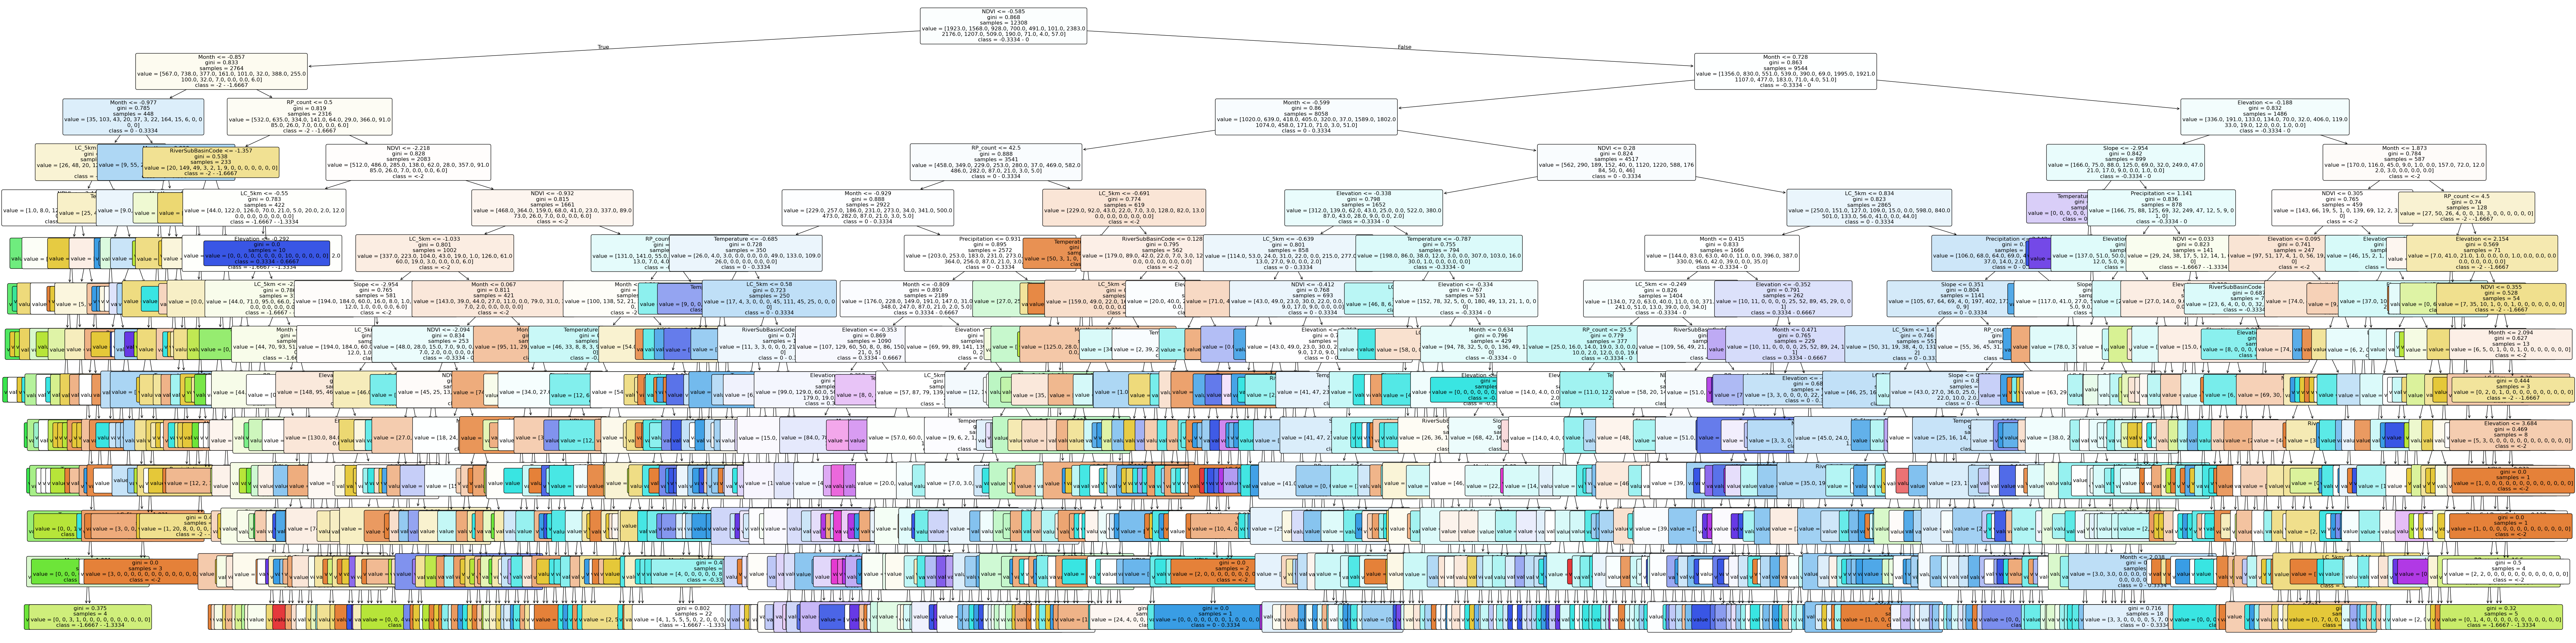

In [35]:
from sklearn.tree import plot_tree

# defining feature and class names
feature_names = X.columns.tolist()

class_names = ['<-2', '-2 - -1.6667', '-1.6667 - -1.3334', '-1.3334 - -1.0', '-1.0 - -0.6667', '-0.6667 - -0.3334', '-0.3334 - 0', '0 - 0.3334', '0.3334 - 0.6667', '0.6667 - 1.0', '1.0 - 1.3334', '1.3334 - 1.6667', '1.6667 - 2.0', '>2.0']

# plotting decision tree
plt.figure(figsize=(80, 20))
plot_tree(CART_best_model, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.tight_layout()
plt.savefig("../imgs/CART_decision_tree.png")
plt.show()

Importance Rank for each Feature:
    Rank #1: Precipitation, mean_importance = 0.030528279294542708
    Rank #2: RiverSubBasinCode, mean_importance = 0.04089732273304064
    Rank #3: Slope, mean_importance = 0.04110162763160147
    Rank #4: Temperature, mean_importance = 0.11058034830890433
    Rank #5: RP_count, mean_importance = 0.11496813673752745
    Rank #6: LC_5km, mean_importance = 0.13305509613227948
    Rank #7: Elevation, mean_importance = 0.14760531594120688
    Rank #8: NDVI, mean_importance = 0.15132040714365974
    Rank #9: Month, mean_importance = 0.2299434660772372


<Figure size 1500x1000 with 0 Axes>

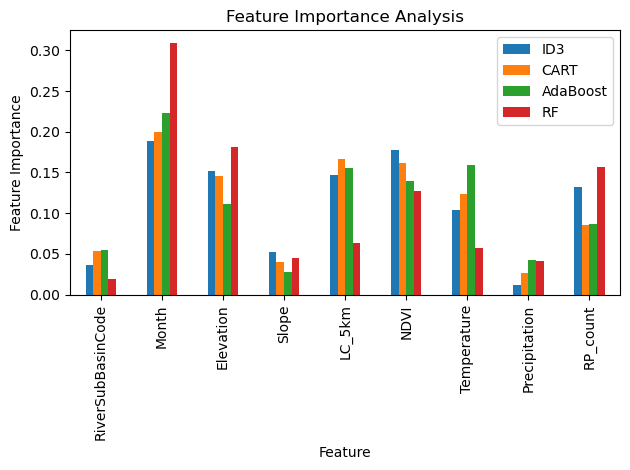

In [36]:
import numpy as np
# Initialize figure and axes for subplots
#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.figure(figsize = (15,10))


# feature importance for id3_best_model
id3_importance = id3_best_model.feature_importances_

# feature importance for CART_best_model
CART_importance = CART_best_model.feature_importances_

# feature importance for ada_best_model
ada_importance = ada_best_model.feature_importances_

# feature importance for rf best_model
rf_importance = best_model.feature_importances_

#preparing data
importance = []
importance.append(id3_importance)
importance.append(CART_importance)
importance.append(ada_importance)
importance.append(rf_importance)
importance = pd.DataFrame(np.transpose(np.array(importance)),index=X.columns.tolist(), columns = ['ID3', 'CART', 'AdaBoost', 'RF'])

# ranking feature importance based on mean importance across all models
importance_mean = importance.mean(axis=1)
importance_mean = importance_mean.sort_values()
print('Importance Rank for each Feature:')
count = 1
for index, value in importance_mean.items():
    print(f"    Rank #{str(count)}: {index}, mean_importance = {str(value)}")
    count+=1

#plotting bar chart
importance.plot.bar()
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Analysis')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('../imgs/Feature_Importance.png')
plt.show()